In [2]:
#importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#importing nltk libraries
import nltk
#nltk.download('all')
from nltk.corpus import stopwords
import re
import string
from nltk import FreqDist
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import FreqDist

from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score,precision_score, confusion_matrix, accuracy_score,classification_report

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB, GaussianNB,BernoulliNB
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost.sklearn import XGBClassifier

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
#loading the data into a dataframe
df = pd.read_csv("Rating Prediction.csv")
df

,Unnamed: 0,Review_title,Reiew_text,Ratings
0,0,Suitable for School kids,\n If you are a College student or a professi...,2.0 out of 5 stars
1,1,Misrepresentation on MS Office 2019 license - ...,\n Update after one month usage - MS Office 2...,2.0 out of 5 stars
2,2,The sold me renewed laptop,\n It’s look like renewed laptop because lapt...,2.0 out of 5 stars
3,3,Amazon dupes with specification/ battery sucks,\n &nbsp;I had seen the specifications and bo...,2.0 out of 5 stars
4,4,Display back light issue,\n Display gone with 2 months.. But anyway th...,2.0 out of 5 stars
...,...,...,...,...
77545,77545,Nice product,good product,4
77546,77546,Awesome,Very good as expected and happy with the purchase,5
77547,77547,Awesome,I love it! No complaint!,5
77548,77548,Nice product,good product,4


In [4]:
df.drop(columns = 'Unnamed: 0',inplace = True)

In [5]:
#checking the shape
print("Shape :", df.shape)

Shape : (77550, 3)


In [6]:
#checking column names
print("Columns :", df.columns)

Columns : Index(['Review_title', 'Reiew_text', 'Ratings'], dtype='object')


In [7]:
#data types
df.dtypes

Review_title    object
Reiew_text      object
Ratings         object
dtype: object

In [8]:
#info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77550 entries, 0 to 77549
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Review_title  68521 non-null  object
 1   Reiew_text    69465 non-null  object
 2   Ratings       68523 non-null  object
dtypes: object(3)
memory usage: 1.8+ MB


In [9]:
# Checking missing value 

#missing values
df.isnull().sum()

Review_title    9029
Reiew_text      8085
Ratings         9027
dtype: int64

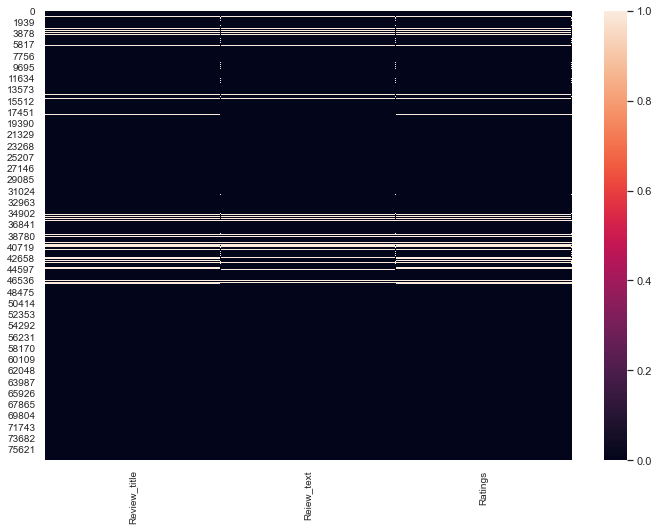

In [10]:
#Visualization of missing values
sns.set(rc={'figure.figsize':(11.8,8.27)})
sns.heatmap(data=df.isnull())
plt.xticks(rotation=90, fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.show()

In [11]:
#Drop the rows where review_title and Reiew_text has null values
df.dropna(subset=['Review_title','Reiew_text'], inplace=True)

In [12]:
#checking for null values again
df.isnull().sum()

Review_title    0
Reiew_text      0
Ratings         0
dtype: int64

Great we have successfully removed all the missing data from our data set.

In [13]:
#lets check the shape of our data set now
df.shape

(68294, 3)

In [14]:
#Lets have a look at our target column


df['Ratings'].unique()

array(['2.0 out of 5 stars', '3.0 out of 5 stars', '1.0 out of 5 stars',
       '5.0 out of 5 stars', '4.0 out of 5 stars', '5', '1', '4', '3',
       '2'], dtype=object)

In [15]:
df['Ratings'] = df['Ratings'].replace('1.0 out of 5 stars',1)
df['Ratings'] = df['Ratings'].replace('2.0 out of 5 stars',2)
df['Ratings'] = df['Ratings'].replace('3.0 out of 5 stars',3)
df['Ratings'] = df['Ratings'].replace('4.0 out of 5 stars',4)
df['Ratings'] = df['Ratings'].replace('5.0 out of 5 stars',5)
df['Ratings'] = df['Ratings'].astype('int')

In [16]:
df['Ratings'].unique()

array([2, 3, 1, 5, 4])

In [17]:
#Combine Review_title and Reiew_text into one


#joining Review text and title
df['Review'] = df['Review_title'].map(str)+' '+df['Reiew_text']

#lets have a look at our data now
df

,Review_title,Reiew_text,Ratings,Review
0,Suitable for School kids,\n If you are a College student or a professi...,2,Suitable for School kids \n If you are a Coll...
1,Misrepresentation on MS Office 2019 license - ...,\n Update after one month usage - MS Office 2...,2,Misrepresentation on MS Office 2019 license - ...
2,The sold me renewed laptop,\n It’s look like renewed laptop because lapt...,2,The sold me renewed laptop \n It’s look like ...
3,Amazon dupes with specification/ battery sucks,\n &nbsp;I had seen the specifications and bo...,2,Amazon dupes with specification/ battery sucks...
4,Display back light issue,\n Display gone with 2 months.. But anyway th...,2,Display back light issue \n Display gone with...
...,...,...,...,...
77545,Nice product,good product,4,Nice product good product
77546,Awesome,Very good as expected and happy with the purchase,5,Awesome Very good as expected and happy with t...
77547,Awesome,I love it! No complaint!,5,Awesome I love it! No complaint!
77548,Nice product,good product,4,Nice product good product


In [18]:
#Text Processing


#Here I am defining a function to replace some of the contracted words to their full form and removing urls and some unwanted text 
def decontracted(text):
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"don’t", "do not", text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"im ", "i am", text)
    text = re.sub(r"yo ", "you ",text)
    text = re.sub(r"doesn’t", "does not",text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"<br>", " ", text)
    text = re.sub(r'http\S+', '', text) #removing urls
    return text


In [19]:

#Lowercasing
df['Review'] = df['Review'].apply(lambda x : x.lower())

df['Review'] = df['Review'].apply(lambda x : decontracted(x))

#removing punctuations
df['Review'] = df['Review'].str.replace('[^\w\s]','')
df['Review'] = df['Review'].str.replace('\n',' ')

In [20]:

#Remove stopwords
stop = stopwords.words('english')
df['Review'] = df['Review'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [21]:
df['Review'][0]

'suitable school kids college student professional depends heavily laptop pretty much everyday laptop hangs often runs cannot install essential computer science software eclipse android studio laptop dies took laptop thinking good performance based configuration someone wants attend online classes browse may go laptop'

In [22]:
df['Review'][1]

'misrepresentation ms office 2019 license one month trial update one month usage ms office 2019 preinstalled edition became unlicensed version within 30 days refused activate hp support shared product sheet stated laptop came trial version ms office 2019 chasing seller appario retail honour commitment bad experience paying high price around 67000 preinstalled genuine software wise product sleek looks superfast fingerprint scanner good display responsive touchpad decent tinny speakers usb c barrel plug charging options 10 second boot ssd drive preloaded win10 home ms office sure whether trial full version drawbacks weighs 142 kg base gets warm rather quickly power adapter decent college student'

In [23]:
df['Review'][2]

'sold renewed laptop look like renewed laptop laptop charging jack loose left side speaker sounds like tear bad sound quality finger sensor quality look like 2011 touch phone wing chinese phone touch waste money one thing day day amazon product quality getting poor'

In [24]:
#Lemmatization


#Defining functiom to convert nltk tag to wordnet tags
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

In [25]:
#defining function to lemmatize our text

def lemmatize_sentence(sentence):
    #tokenize the sentence & find the pos tag
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x : (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatize_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            lemmatize_sentence.append(word)
        else:
            lemmatize_sentence.append(lemmatizer.#lets have a look at our data set
dflemmatize(word,tag))
    return " ".join(lemmatize_sentence)

In [26]:
#Text Normalization - Standardization


#Noice removal
def scrub_words(text):
    #remove html markup
    text = re.sub("(<.*?>)", "", text)
    #remove non-ascii and digits
    text = re.sub("(\\W)", " ", text)
    text = re.sub("(\\d)", "", text)
    #remove white space
    text = text.strip()
    return text
df['Review'] = df['Review'].apply(lambda x : scrub_words(x))

In [27]:
df['Review'][0]

'suitable school kids college student professional depends heavily laptop pretty much everyday laptop hangs often runs cannot install essential computer science software eclipse android studio laptop dies took laptop thinking good performance based configuration someone wants attend online classes browse may go laptop'

In [28]:
df['Review'][1]

'misrepresentation ms office  license one month trial update one month usage ms office  preinstalled edition became unlicensed version within  days refused activate hp support shared product sheet stated laptop came trial version ms office  chasing seller appario retail honour commitment bad experience paying high price around  preinstalled genuine software wise product sleek looks superfast fingerprint scanner good display responsive touchpad decent tinny speakers usb c barrel plug charging options  second boot ssd drive preloaded win home ms office sure whether trial full version drawbacks weighs  kg base gets warm rather quickly power adapter decent college student'

In [29]:
#Exploratory Data Analysis

#Word Counts

#creating column for word counts in the text

df['Review_WC'] = df['Review'].apply(lambda x: len(str(x).split(' ')))
df[['Review_WC','Review']].head()

,Review_WC,Review
0,43,suitable school kids college student professio...
1,103,misrepresentation ms office license one month...
2,43,sold renewed laptop look like renewed laptop l...
3,21,amazon dupes specification battery sucks nbspi...
4,16,display back light issue display gone months ...


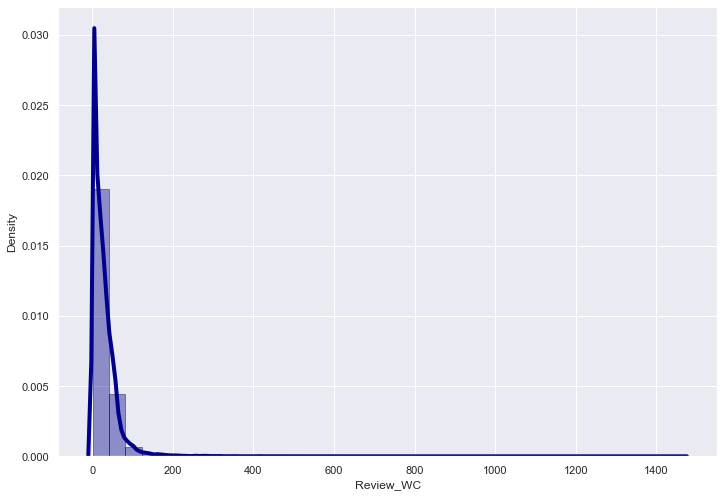

In [30]:
#density plot and histogram of all word count
sns.distplot(df['Review_WC'], hist = True, kde = True,
            bins = int(180/5), color = 'darkblue',
            hist_kws = {'edgecolor':'black'},
            kde_kws = {'linewidth':4})
plt.show()


In [31]:
#Character count
#creating column for character counts in the text
df['Review_CC'] = df['Review'].str.len()
df[['Review_CC','Review']].head()

,Review_CC,Review
0,318,suitable school kids college student professio...
1,675,misrepresentation ms office license one month...
2,260,sold renewed laptop look like renewed laptop l...
3,138,amazon dupes specification battery sucks nbspi...
4,110,display back light issue display gone months ...


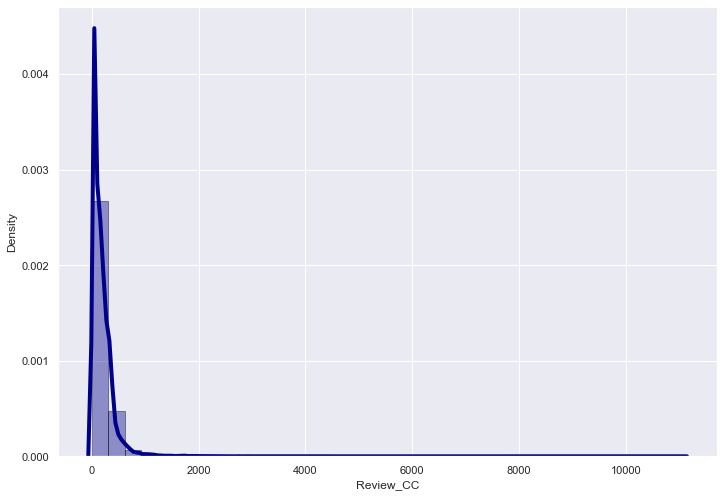

In [32]:
#density plot and histogram of all character count
sns.distplot(df['Review_CC'], hist = True, kde = True,
            bins = int(180/5), color = 'darkblue',
            hist_kws = {'edgecolor':'black'},
            kde_kws = {'linewidth':4})
plt.show()

In [33]:
#Removing Outliers

#As we know that some of the review are too lengthy I am removing those reviews from the dats as outliers using z_score method.

#apply zscore to remove outliers
from scipy import stats
from scipy.stats import zscore
z_score = zscore(df[['Review_WC']])
abs_z_score = np.abs(z_score)
filtering_entry = (abs_z_score < 3).all(axis = 1)
df = df[filtering_entry]
df.shape

(67261, 6)

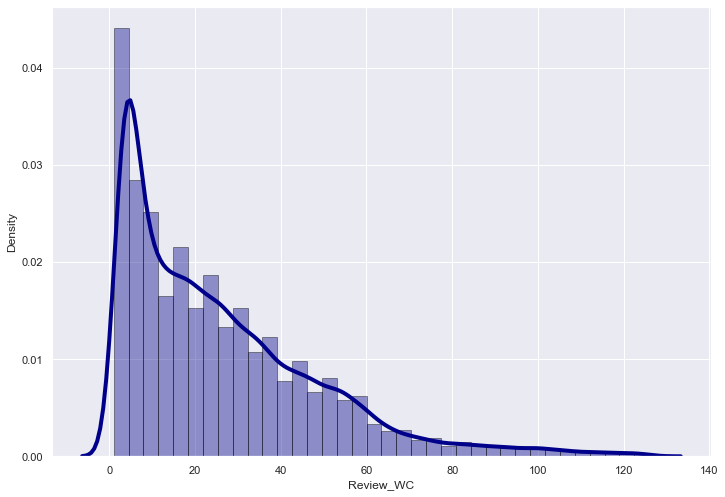

In [34]:
#Plotting histograms for word count and character counts again after removing outliers

#density plot and histogram of all word count

sns.distplot(df['Review_WC'], hist = True, kde = True,
            bins = int(180/5), color = 'darkblue',
            hist_kws = {'edgecolor':'black'},
            kde_kws = {'linewidth':4})
plt.show()

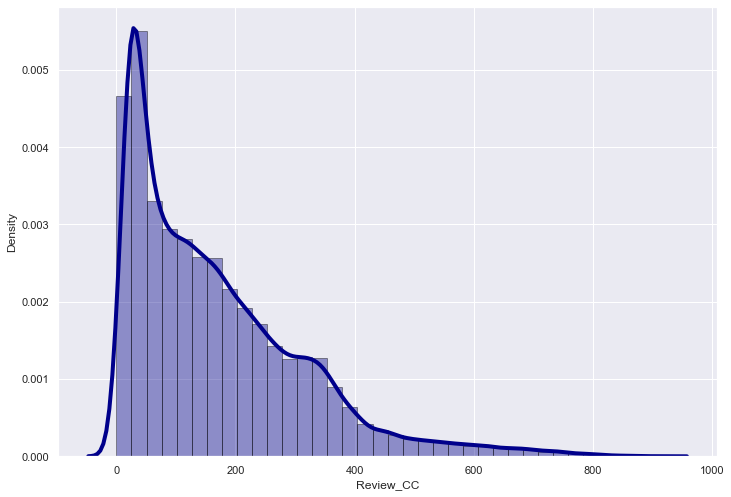

In [35]:
#density plot and histogram of all word count
sns.distplot(df['Review_CC'], hist = True, kde = True,
            bins = int(180/5), color = 'darkblue',
            hist_kws = {'edgecolor':'black'},
            kde_kws = {'linewidth':4})
plt.show()

In [36]:
#lets have a look at our data set
df

,Review_title,Reiew_text,Ratings,Review,Review_WC,Review_CC
0,Suitable for School kids,\n If you are a College student or a professi...,2,suitable school kids college student professio...,43,318
1,Misrepresentation on MS Office 2019 license - ...,\n Update after one month usage - MS Office 2...,2,misrepresentation ms office license one month...,103,675
2,The sold me renewed laptop,\n It’s look like renewed laptop because lapt...,2,sold renewed laptop look like renewed laptop l...,43,260
3,Amazon dupes with specification/ battery sucks,\n &nbsp;I had seen the specifications and bo...,2,amazon dupes specification battery sucks nbspi...,21,138
4,Display back light issue,\n Display gone with 2 months.. But anyway th...,2,display back light issue display gone months ...,16,110
...,...,...,...,...,...,...
77545,Nice product,good product,4,nice product good product,4,25
77546,Awesome,Very good as expected and happy with the purchase,5,awesome good expected happy purchase,5,36
77547,Awesome,I love it! No complaint!,5,awesome love complaint,3,22
77548,Nice product,good product,4,nice product good product,4,25


5    26839
4    13711
1    10316
3     9039
2     7356
Name: Ratings, dtype: int64


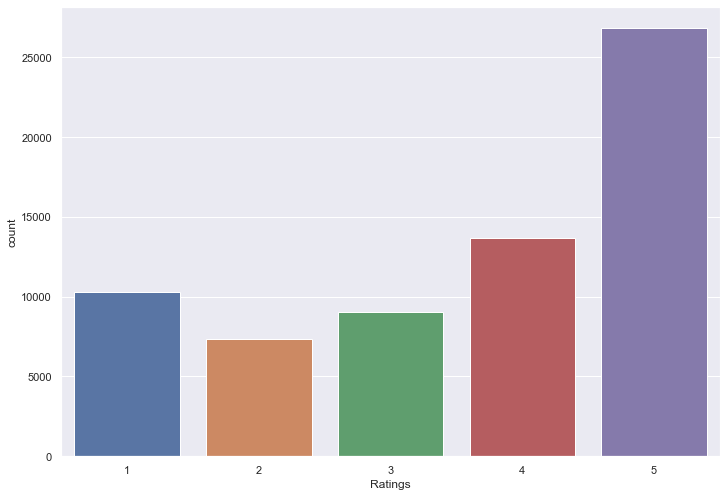

In [37]:
#Check the count of target column
sns.countplot(df['Ratings'])
print(df.Ratings.value_counts())
plt.show()

In [38]:
#shuffling the data set
df = df.sample(frac=1).reset_index(drop=True)
df

,Review_title,Reiew_text,Ratings,Review,Review_WC,Review_CC
0,Mind-blowing purchase,GO FOR IT\n\nIts value for money\n\n\nNo backl...,5,mindblowing purchase go value money backlight ...,21,128
1,Watch is good but it seems it is used before,\n Packaging is not good . It seems used watc...,3,watch good seems used packaging good seems use...,27,168
2,Below average for the price,\n I have used this and compared with one of ...,3,average price used compared one chip one found...,37,247
3,Classy product,I am writing this review after using for 7 day...,5,classy product writing review using days fant...,23,155
4,Wonderful,The watch has a great design looks very premiu...,4,wonderful watch great design looks premium rob...,56,337
...,...,...,...,...,...,...
67256,Loved it,\n I gave gift for my dad 🥰<br>He loved it ve...,5,loved gave gift dad loved much thanks amazon w...,19,124
67257,Moderate,Bad product,2,moderate bad product,3,20
67258,Alright for 15 to 30 minutes of usage,\n Not recommended for prolonged usage due to...,3,alright minutes usage recommended prolonged ...,27,189
67259,Horrible,Waste and werast cemara,1,horrible waste werast cemara,4,28


In [39]:
#selct data from every category
df1 = df[df['Ratings']==1][0:7356]
df2 = df[df['Ratings']==2][0:7356]
df3 = df[df['Ratings']==3][0:7356]
df4 = df[df['Ratings']==4][0:7356]
df5 = df[df['Ratings']==5][0:7356]


#Combining all the dataframes into one and shuffling them 
df = pd.concat([df1,df2,df3,df4,df5],ignore_index=True)
df = df.sample(frac=1).reset_index(drop=True)
df

,Review_title,Reiew_text,Ratings,Review,Review_WC,Review_CC
0,Network stability is not good,\n Network capabilities\n,2,network stability good network capabilities,5,43
1,Delightful,I'm writing this review after 48hrs of use. I'...,4,delightful writing review hrs use promoting sa...,51,322
2,Fantastic but Stopped working in a week😑,\n The Boat Bassheads 100 is a very quality p...,3,fantastic stopped working week boat bassheads ...,66,421
3,Missing central pin from hot shoe,\n The worst thing about the camera that they...,2,missing central pin hot shoe worst thing camer...,20,127
4,"Camera is awesome, but seller has priced it to...","\n Camera is really good, but available outsi...",3,camera awesome seller priced high camera reall...,13,87
...,...,...,...,...,...,...
36775,Poor camera quality,"\n Extremely poor camera quality, which makes...",1,poor camera quality extremely poor camera qual...,20,149
36776,Value for the money .,\n Super..\n,5,value money super,3,17
36777,Not recommended at all,If you want a budget smart phone in this range...,1,recommended want budget smart phone range mobi...,63,397
36778,Fabulous!,Sound is very clear song play excellent i like...,5,fabulous sound clear song play excellent like ...,21,133


1    7356
2    7356
3    7356
4    7356
5    7356
Name: Ratings, dtype: int64


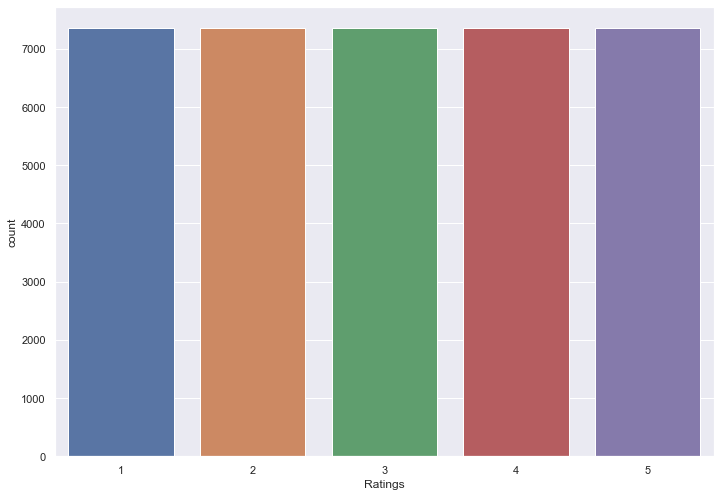

In [40]:
#lets Check the count of target column again
sns.countplot(df['Ratings'])
print(df.Ratings.value_counts())
plt.show()

In [41]:
#Top 30 most frequently occuring words

#function to plot most frequent terms

def freq_words(x, terms = 30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()
    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()),
                             'count':list(fdist.values())})
    #selecting top 30 most freq words
    d = words_df.nlargest(columns = 'count', n = terms)
    plt.figure(figsize = (20,10))
    ax = sns.barplot(data = d, x='count', y='word')
    ax.set(ylabel = 'Word')
    plt.show()

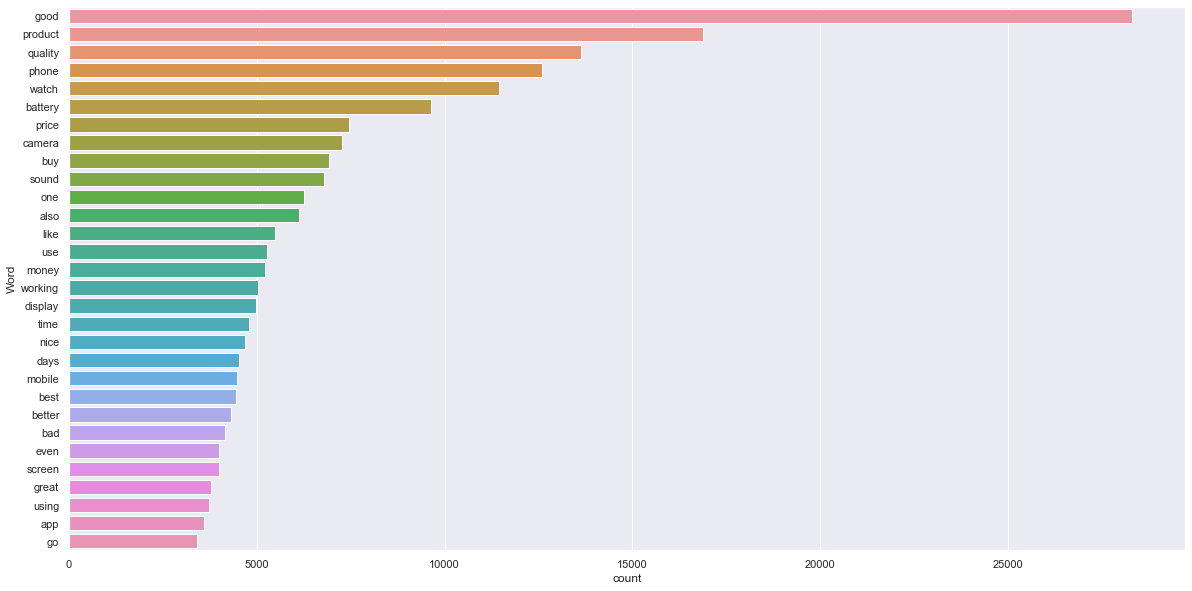

In [42]:
freq_words(df['Review'])

In [43]:
#Top 30 Rare words

#function to plot least frequent terms

def rare_words(x, terms = 30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()
    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()),
                             'count':list(fdist.values())})
    #selecting top 30 most freq words
    d = words_df.nsmallest(columns = 'count', n = terms)
    plt.figure(figsize = (20,10))
    ax = sns.barplot(data = d, x='count', y='word')
    ax.set(ylabel = 'Word')
    plt.show()

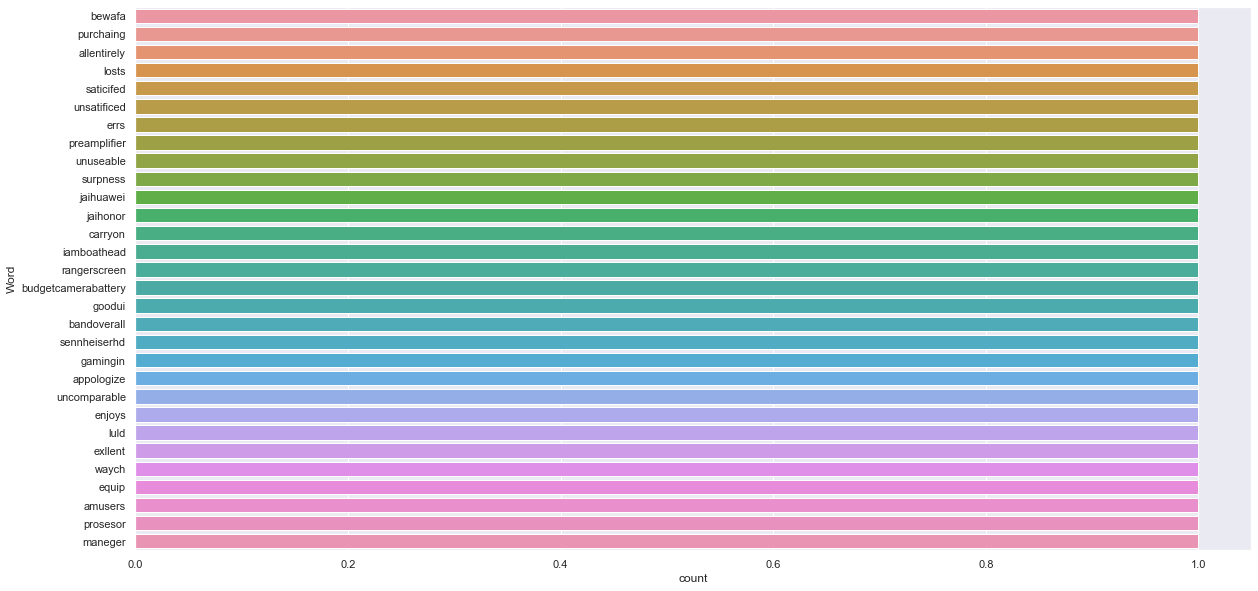

In [44]:
rare_words(df['Review'])

In [45]:
#Word cloud



from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
                    background_color='white',
                    stopwords = stopwords,
                    max_words = 500,
                    max_font_size = 40,
                    scale = 3,
                    random_state = 1).generate(str(data))
    fig = plt.figure(1, figsize=(15,15))
    plt.axis('off')
    if title:
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)
    plt.imshow(wordcloud)
    plt.show()

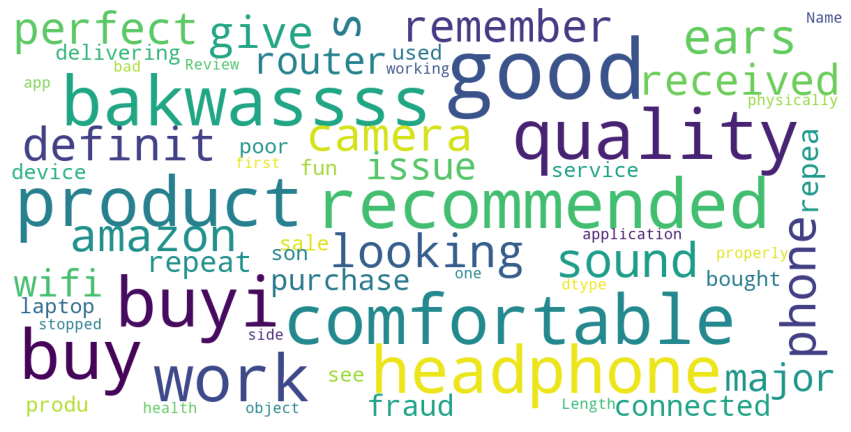

In [46]:
#Words for rating = 1:
    
    
show_wordcloud(df1['Review'])

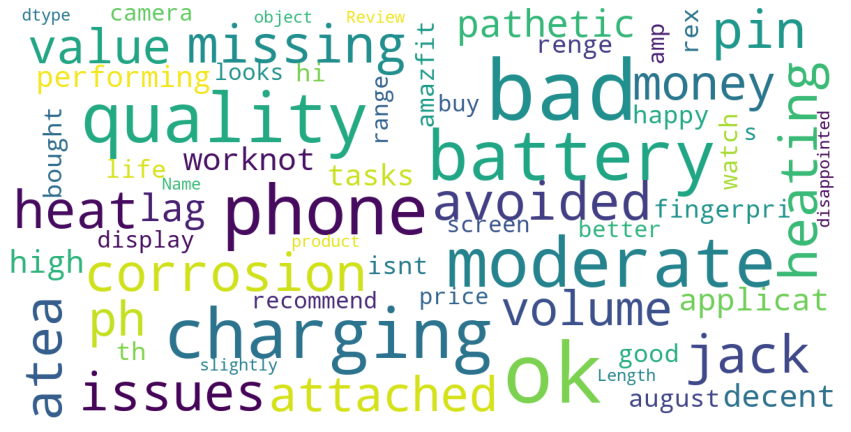

In [47]:
#Words for rating = 2:


show_wordcloud(df2['Review'])

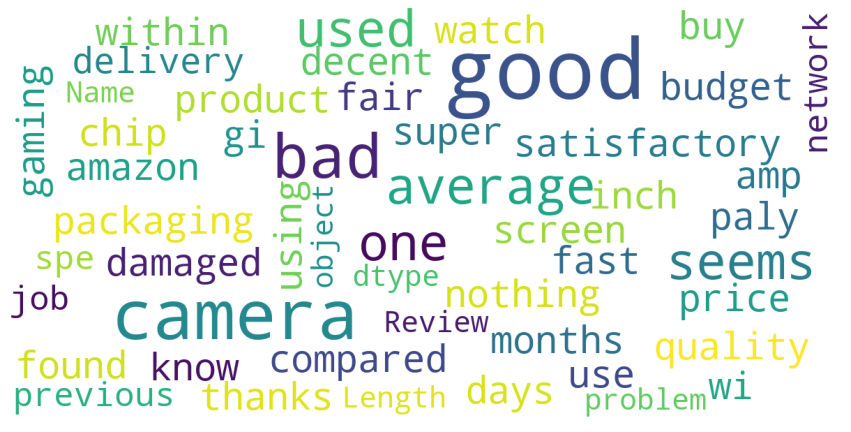

In [48]:
#Words for rating = 3:


show_wordcloud(df3['Review'])

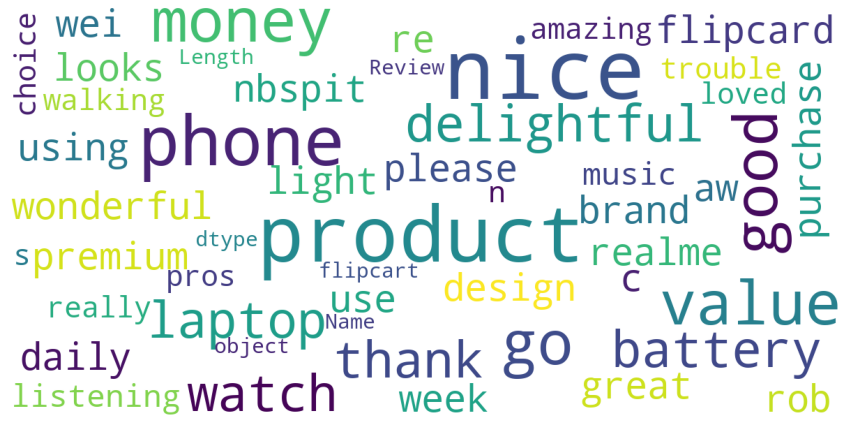

In [49]:
#Words for rating = 4:
    
    
show_wordcloud(df4['Review'])

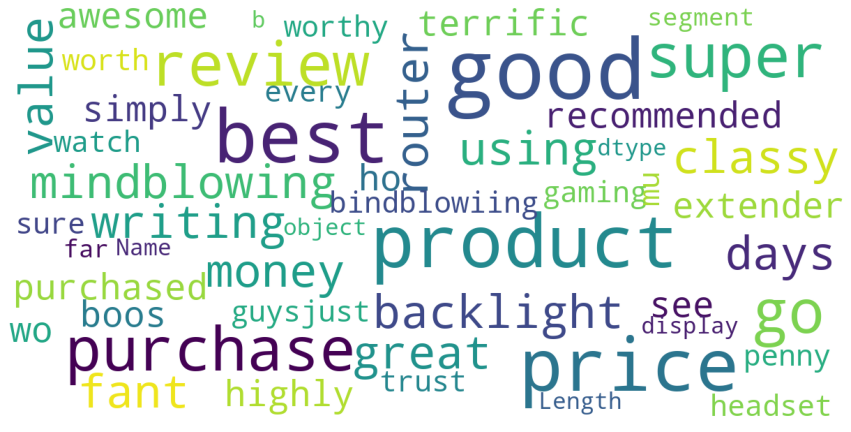

In [50]:
#Words for rating = 5:


show_wordcloud(df5['Review'])


In [51]:
#Model Building and Evaluation

#separating features and labels

x = df['Review']
y = df['Ratings']

In [52]:
#Converting text into vectors using TfidfVectorizer

#using the n_gram tfidf vectorizer(Word vectors)

word_vectorizer = TfidfVectorizer(
                                sublinear_tf = True,
                                strip_accents = 'unicode',
                                analyzer = 'word',
                                token_pattern = r'\w{1,}',
                                stop_words = 'english',
                                ngram_range = (1,3),
                                max_features = 100000)
word_vectorizer.fit(x)
train_word_features = word_vectorizer.transform(x)

In [53]:
#Character vectors
char_vectorizer = TfidfVectorizer(
                                sublinear_tf = True,
                                strip_accents = 'unicode',
                                analyzer = 'char',
                                stop_words = 'english',
                                ngram_range = (2,6),
                                max_features = 50000)
char_vectorizer.fit(x)
train_char_features = char_vectorizer.transform(x)


In [54]:
#I will combine both word vectors and character vectors as input for our model

train_features = hstack([train_char_features,train_word_features])

In [55]:
#Splitting the data into train and test


seed = 1
x_train, x_test, y_train, y_test = train_test_split(train_features, y, test_size = 0.25, random_state = seed)


In [56]:
#lets check the shapes of traning and test data
print("x_train", x_train.shape)
print("x_test", x_test.shape)
print("y_train", y_train.shape)
print("y_test", y_test.shape)

x_train (27585, 150000)
x_test (9195, 150000)
y_train (27585,)
y_test (9195,)


In [57]:
#defining the algorithms
rf = RandomForestClassifier()
svc = LinearSVC()
lr = LogisticRegression(solver='lbfgs')
mnb = MultinomialNB()
xgb = XGBClassifier(verbosity=0)
bnb = BernoulliNB()
lgb = LGBMClassifier()
sgd = SGDClassifier()

In [58]:
#creating a function to train and test the model with evaluation
def BuiltModel(model):
    print('*'*30+model.__class__.__name__+'*'*30)
    model.fit(x_train,y_train)
    y_pred = model.predict(x_train)
    pred = model.predict(x_test)

    accuracy = accuracy_score(y_test,pred)*100

    print(f"Accuracy Score:", accuracy)
    print("---------------------------------------------------")

    #confusion matrix & classification report
    
    print(f"CLASSIFICATION REPORT : \n {classification_report(y_test,pred)}")
    print(f"Confusion Matrix : \n {confusion_matrix(y_test,pred)}\n")
    

In [59]:
#Training and testing of various algorithms

for model in [lr,svc,bnb,mnb,sgd,rf,xgb]:
    BuiltModel(model)

******************************LogisticRegression******************************
Accuracy Score: 70.58183795541055
---------------------------------------------------
CLASSIFICATION REPORT : 
               precision    recall  f1-score   support

           1       0.73      0.77      0.75      1809
           2       0.62      0.63      0.62      1830
           3       0.63      0.61      0.62      1821
           4       0.70      0.70      0.70      1863
           5       0.84      0.81      0.83      1872

    accuracy                           0.71      9195
   macro avg       0.71      0.71      0.71      9195
weighted avg       0.71      0.71      0.71      9195

Confusion Matrix : 
 [[1401  275  108   17    8]
 [ 333 1146  260   70   21]
 [ 133  315 1107  217   49]
 [  41   82  220 1312  208]
 [  18   23   60  247 1524]]

******************************LinearSVC******************************
Accuracy Score: 71.1147362697118
---------------------------------------------------
CL

In [60]:
#Cross validation score


def cross_val(model):
    print('*'*30+model.__class__.__name__+'*'*30)
    scores = cross_val_score(model,train_features,y, cv = 3).mean()*100
    print("Cross validation score :", scores)

In [61]:
for model in [lr,svc,sgd,rf]:
    cross_val(model)

******************************LogisticRegression******************************
Cross validation score : 70.44317563893419
******************************LinearSVC******************************
Cross validation score : 70.45405111473627
******************************SGDClassifier******************************
Cross validation score : 69.71723762914627
******************************RandomForestClassifier******************************
Cross validation score : 70.53017944535074


In [65]:
#HyperParameter Tuning
#lets selects different parameters for tuning
grid_params = {'penalty':['l2'],
                'loss':['hinge','squared_hinge'],
                'multi_class': ['ovr'],
                'intercept_scaling':[2,3],
                'dual':[True,False],}

In [66]:
#train the model with given parameters using GridSearchCV
GCV =  GridSearchCV(svc, grid_params, cv = 3, verbose=10)
GCV.fit(x_train,y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV 1/3; 1/8] START dual=True, intercept_scaling=2, loss=hinge, multi_class=ovr, penalty=l2
[CV 1/3; 1/8] END dual=True, intercept_scaling=2, loss=hinge, multi_class=ovr, penalty=l2; total time= 1.5min
[CV 2/3; 1/8] START dual=True, intercept_scaling=2, loss=hinge, multi_class=ovr, penalty=l2
[CV 2/3; 1/8] END dual=True, intercept_scaling=2, loss=hinge, multi_class=ovr, penalty=l2; total time=  47.8s
[CV 3/3; 1/8] START dual=True, intercept_scaling=2, loss=hinge, multi_class=ovr, penalty=l2
[CV 3/3; 1/8] END dual=True, intercept_scaling=2, loss=hinge, multi_class=ovr, penalty=l2; total time= 1.1min
[CV 1/3; 2/8] START dual=True, intercept_scaling=2, loss=squared_hinge, multi_class=ovr, penalty=l2
[CV 1/3; 2/8] END dual=True, intercept_scaling=2, loss=squared_hinge, multi_class=ovr, penalty=l2; total time=  41.2s
[CV 2/3; 2/8] START dual=True, intercept_scaling=2, loss=squared_hinge, multi_class=ovr, penalty=l2
[CV 2/3; 2/8] EN

GridSearchCV(cv=3, estimator=LinearSVC(),
             param_grid={'dual': [True, False], 'intercept_scaling': [2, 3],
                         'loss': ['hinge', 'squared_hinge'],
                         'multi_class': ['ovr'], 'penalty': ['l2']},
             verbose=10)

In [67]:
GCV.best_params_       #printing the best parameters found by GridSearchCV

{'dual': False,
 'intercept_scaling': 3,
 'loss': 'squared_hinge',
 'multi_class': 'ovr',
 'penalty': 'l2'}

In [68]:
#Final Model

In [69]:
#training and testing our final model with above parameters
model = LinearSVC(dual = True, intercept_scaling = 2, loss = 'hinge', multi_class = 'ovr', penalty = 'l2')
model.fit(x_train,y_train) #fitting data to model
pred = model.predict(x_test)
accuracy = accuracy_score(y_test,pred)*100

#printing accuracy score
print("Accuracy Score :", accuracy)

#printing Confusion matrix
print(f"\nConfusion Matrix : \n {confusion_matrix(y_test,pred)}\n")

#printing Classification report
print(f"\nCLASSIFICATION REPORT : \n {classification_report(y_test,pred)}")

Accuracy Score : 70.70146818923327

Confusion Matrix : 
 [[1425  231  105   29   19]
 [ 362 1157  208   66   37]
 [ 146  313 1080  220   62]
 [  42  100  186 1299  236]
 [  21   26   61  224 1540]]


CLASSIFICATION REPORT : 
               precision    recall  f1-score   support

           1       0.71      0.79      0.75      1809
           2       0.63      0.63      0.63      1830
           3       0.66      0.59      0.62      1821
           4       0.71      0.70      0.70      1863
           5       0.81      0.82      0.82      1872

    accuracy                           0.71      9195
   macro avg       0.71      0.71      0.71      9195
weighted avg       0.71      0.71      0.71      9195



In [70]:
#Model Saving


import joblib
joblib.dump(model,"Rating_Prediction.pkl")

['Rating_Prediction.pkl']